
# Clase 1 – Predicción de *Churn* (Clasificación) y Costo Mensual (Regresión)

Este notebook descarga el **dataset público Telco Customer Churn**, realiza:
- **Clasificación:** predicción de abandono (churn).
- **Regresión:** predicción de **cargo mensual** (*MonthlyCharges*).

Incluye preparación de datos, modelos base, métricas, **ajuste de umbral** y comparación con un **bosque aleatorio**.


In [2]:

# (Opcional) instala dependencias si hace falta
!pip install -q pandas numpy scikit-learn imbalanced-learn matplotlib requests joblib



## 1. Descargar datos (fuente pública)


In [ ]:

import os, requests

CANDIDATE_URLS = [
    "https://raw.githubusercontent.com/IBM/telco-customer-churn-model/master/data/WA_Fn-UseC_-Telco-Customer-Churn.csv",
    "https://raw.githubusercontent.com/blastchar/telco-customer-churn/master/WA_Fn-UseC_-Telco-Customer-Churn.csv",
]

dest_path = "telco_churn.csv"
last_err = None
for url in CANDIDATE_URLS:
    try:
        r = requests.get(url, timeout=20)
        r.raise_for_status()
        with open(dest_path, "wb") as f:
            f.write(r.content)
        print("Descargado:", url, "->", dest_path, f"({len(r.content)} bytes)")
        last_err = None
        break
    except Exception as e:
        last_err = e
        print("Fallo con:", url, "->", repr(e))

if last_err:
    raise SystemExit("No fue posible descargar el dataset. Prueba ejecutar de nuevo o cambia los enlaces.")



## 2. Cargar y preparar datos


In [ ]:

import pandas as pd
import numpy as np

df = pd.read_csv("telco_churn.csv")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges']).reset_index(drop=True)

y_class = df['Churn'].str.strip().str.lower().map({'yes':1, 'no':0}).astype(int)
X = df.drop(columns=['customerID', 'Churn'])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_class, test_size=0.2, random_state=42, stratify=y_class
)

cat_cols = X_train.select_dtypes(include='object').columns.tolist()
num_cols = X_train.select_dtypes(exclude='object').columns.tolist()

len(df), len(cat_cols), len(num_cols)




0         29.85
1        1889.5
2        108.15
3       1840.75
4        151.65
         ...   
7038     1990.5
7039     7362.9
7040     346.45
7041      306.6
7042     6844.5
Name: TotalCharges, Length: 7043, dtype: object
0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7027    1990.50
7028    7362.90
7029     346.45
7030     306.60
7031    6844.50
Name: TotalCharges, Length: 7032, dtype: float64


(7032, 15, 4)


## 3. Clasificación – Regresión logística (pipeline)


In [10]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", StandardScaler(), num_cols),
])

logreg = Pipeline([
    ("prep", pre),
    ("clf", LogisticRegression(max_iter=300, class_weight="balanced"))
])

logreg.fit(X_train, y_train)
y_prob = logreg.predict_proba(X_test)[:, 1]
y_pred50 = (y_prob >= 0.5).astype(int)

y_prob[:3]


array([0.05047676, 0.78565521, 0.01428964])


## 4. Evaluación de clasificación


              precision    recall  f1-score   support

           0     0.9049    0.6999    0.7893      1033
           1     0.4901    0.7968    0.6069       374

    accuracy                         0.7257      1407
   macro avg     0.6975    0.7483    0.6981      1407
weighted avg     0.7946    0.7257    0.7408      1407

AUC-ROC: 0.8351344145860403
AUC-PR (media de precisión): 0.6183128860330439


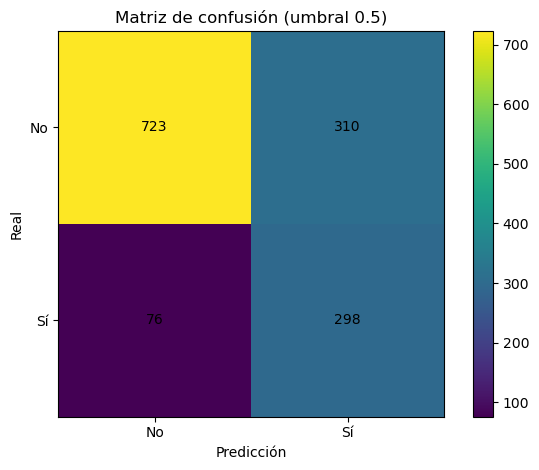

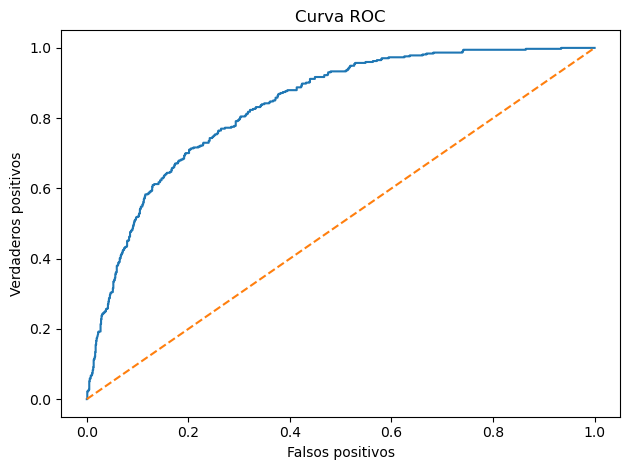

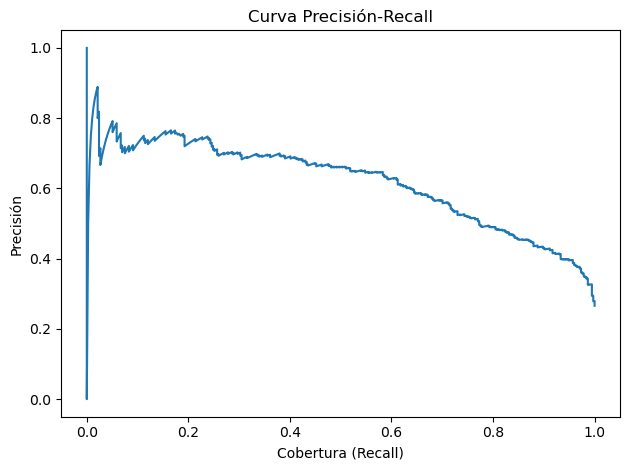

In [11]:

import matplotlib.pyplot as plt
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, roc_curve,
                             precision_recall_curve, average_precision_score)

print(classification_report(y_test, y_pred50, digits=4))
print("AUC-ROC:", roc_auc_score(y_test, y_prob))
print("AUC-PR (media de precisión):", average_precision_score(y_test, y_prob))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred50)
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Matriz de confusión (umbral 0.5)")
plt.colorbar()
plt.xticks([0,1], ["No", "Sí"])
plt.yticks([0,1], ["No", "Sí"])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Predicción"); plt.ylabel("Real")
plt.tight_layout(); plt.show()

# Curva ROC
fpr, tpr, thr = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], linestyle="--")
plt.title("Curva ROC")
plt.xlabel("Falsos positivos"); plt.ylabel("Verdaderos positivos")
plt.tight_layout(); plt.show()

# Curva Precisión-Recall
prec, rec, thr_pr = precision_recall_curve(y_test, y_prob)
plt.figure()
plt.plot(rec, prec)
plt.title("Curva Precisión-Recall")
plt.xlabel("Cobertura (Recall)"); plt.ylabel("Precisión")
plt.tight_layout(); plt.show()



## 5. Ajuste de umbral (max F1)


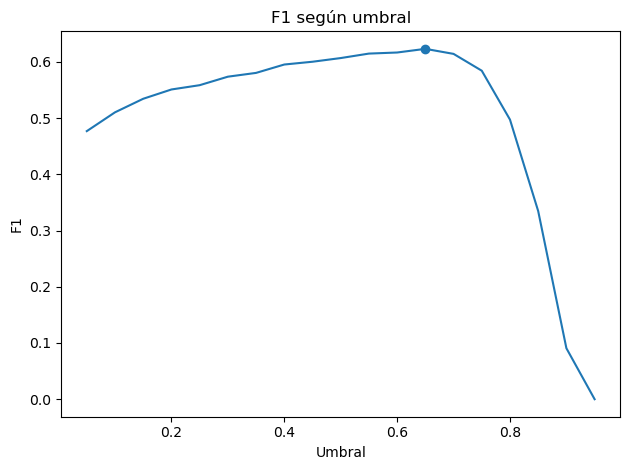

(0.65, 0.6233128834355828)

In [12]:

from sklearn.metrics import f1_score
import numpy as np

ths = np.linspace(0.05, 0.95, 19)
scores = [f1_score(y_test, (y_prob >= t).astype(int)) for t in ths]
best_idx = int(np.argmax(scores))
best_thr, best_f1 = float(ths[best_idx]), float(scores[best_idx])

import matplotlib.pyplot as plt
plt.figure()
plt.plot(ths, scores); plt.scatter([best_thr],[best_f1])
plt.title("F1 según umbral"); plt.xlabel("Umbral"); plt.ylabel("F1")
plt.tight_layout(); plt.show()

best_thr, best_f1



## 6. Bosque aleatorio – comparación


In [13]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, average_precision_score, roc_auc_score

rf = Pipeline([("prep", pre), ("clf", RandomForestClassifier(n_estimators=300, random_state=42))])
rf.fit(X_train, y_train)

rf_prob = rf.predict_proba(X_test)[:,1]
rf_pred = (rf_prob >= best_thr).astype(int)

print("Bosque → AUC-ROC:", roc_auc_score(y_test, rf_prob))
print("Bosque → AUC-PR:", average_precision_score(y_test, rf_prob))
print(classification_report(y_test, rf_pred, digits=4))


Bosque → AUC-ROC: 0.8121599515455218
Bosque → AUC-PR: 0.5932501455516038
              precision    recall  f1-score   support

           0     0.7998    0.9400    0.8643      1033
           1     0.6788    0.3503    0.4621       374

    accuracy                         0.7832      1407
   macro avg     0.7393    0.6451    0.6632      1407
weighted avg     0.7677    0.7832    0.7574      1407




## 7. Regresión – predecir `MonthlyCharges`


Lineal 
MAE: 0.784  RMSE: 1.037  R²: 0.999
Ridge 
MAE: 0.784  RMSE: 1.037  R²: 0.999
Lasso 
MAE: 0.94  RMSE: 1.218  R²: 0.998


c:\Users\vedra\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vedra\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vedra\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


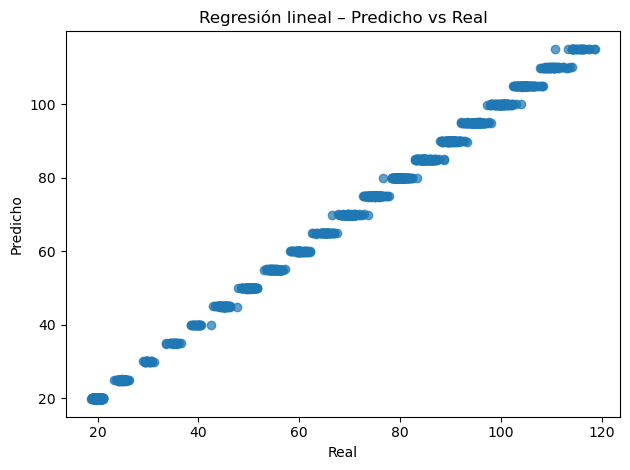

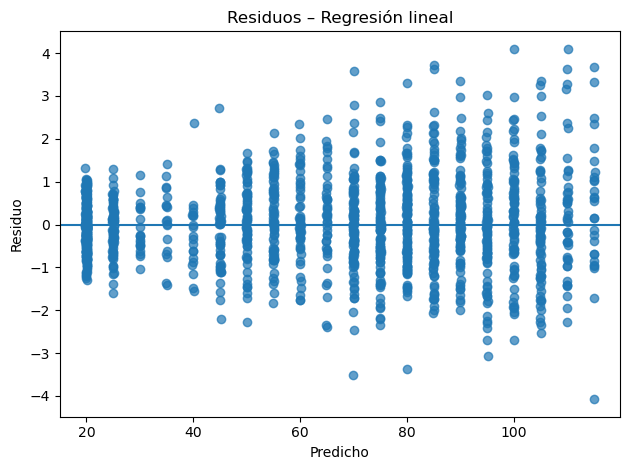

In [14]:

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_reg = df['MonthlyCharges']
Xr = df.drop(columns=['customerID','Churn','MonthlyCharges'])

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    Xr, y_reg, test_size=0.2, random_state=42
)

cat_cols_r = Xr_train.select_dtypes(include='object').columns.tolist()
num_cols_r = Xr_train.select_dtypes(exclude='object').columns.tolist()

pre_r = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_r),
    ("num", StandardScaler(), num_cols_r),
])

lin = Pipeline([("prep", pre_r), ("reg", LinearRegression())]).fit(Xr_train, yr_train)
pred_lin = lin.predict(Xr_test)

def report_reg(y_true, y_pred, titulo):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(titulo, "\nMAE:", round(mae,3), " RMSE:", round(rmse,3), " R²:", round(r2,3))

report_reg(yr_test, pred_lin, "Lineal")

ridge = Pipeline([("prep", pre_r), ("reg", Ridge(alpha=1.0))]).fit(Xr_train, yr_train)
report_reg(yr_test, ridge.predict(Xr_test), "Ridge")

lasso = Pipeline([("prep", pre_r), ("reg", Lasso(alpha=0.1, max_iter=10000))]).fit(Xr_train, yr_train)
report_reg(yr_test, lasso.predict(Xr_test), "Lasso")

# Gráficos
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(yr_test, pred_lin, alpha=0.7)
plt.xlabel("Real"); plt.ylabel("Predicho"); plt.title("Regresión lineal – Predicho vs Real")
plt.tight_layout(); plt.show()

res = yr_test - pred_lin
plt.figure()
plt.scatter(pred_lin, res, alpha=0.7); plt.axhline(0)
plt.xlabel("Predicho"); plt.ylabel("Residuo"); plt.title("Residuos – Regresión lineal")
plt.tight_layout(); plt.show()



## 8. Guardar pipelines


In [ ]:

import joblib
joblib.dump(logreg, "pipeline_churn_logistica.joblib")
joblib.dump(rf, "pipeline_churn_bosque.joblib")
joblib.dump(lin, "pipeline_regresion_lineal.joblib")
joblib.dump(logreg,"telco_churn_model.pkl")
"Listo"


'Listo'

: 